In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from collections import deque
import random
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

In [2]:
# Define the DQN model
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(self._feature_size(input_shape), 512)
        self.fc2 = nn.Linear(512, num_actions)

    def _feature_size(self, input_shape):
        return self.conv3(self.conv2(self.conv1(torch.zeros(1, *input_shape)))).view(1, -1).size(1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [3]:
# Experience replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.stack(state), action, reward, np.stack(next_state), done

    def __len__(self):
        return len(self.buffer)

In [4]:
# Preprocess the state 
def preprocess_state(state):
    if isinstance(state, tuple):
        state = state[0]
    state = np.array(state)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(),
        transforms.Resize((84, 84)),
        transforms.ToTensor()
    ])
    state = transform(state)
    return state

In [5]:
# Stack frames to create the state representation
def stack_frames(frames):
    return torch.cat(frames, dim=0)

# Initialize environment, model, and replay buffer
env = gym.make('Breakout-v0')
input_shape = (4, 84, 84)  # Stack of 4 frames
num_actions = env.action_space.n
model = DQN(input_shape, num_actions)
target_model = DQN(input_shape, num_actions)
target_model.load_state_dict(model.state_dict())
optimizer = optim.Adam(model.parameters(), lr=0.0001)
replay_buffer = ReplayBuffer(10000)

C:\Users\Hp\AppData\Roaming\Python\Python311\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment Breakout-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(


In [6]:
# Parameters
gamma = 0.99
batch_size = 32
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.995
target_update_freq = 1000
num_episodes = 200
max_steps = 10000

In [7]:
# Main training loop
episode_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    state = preprocess_state(state).unsqueeze(0)
    frames = deque([state] * 4, maxlen=4)  

    total_reward = 0
    done = False

    for step in range(max_steps):
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                stacked_state = torch.cat(list(frames), dim=1)
                action = model(stacked_state).argmax().item()

        result = env.step(action)
        if len(result) == 4:
            next_state, reward, done, _ = result
        elif len(result) == 5:
            next_state, reward, done, truncated, _ = result
            done = done or truncated
        else:
            raise ValueError(f"Unexpected number of values returned by env.step(action): {len(result)}")

        next_state = preprocess_state(next_state).unsqueeze(0)
        frames.append(next_state)

        stacked_state = torch.cat(list(frames), dim=1)
        replay_buffer.add(stacked_state, action, reward, torch.cat(list(frames), dim=1), done)
        state = next_state
        total_reward += reward

        if done:
            break

        if len(replay_buffer) > batch_size:
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            states = torch.tensor(states, dtype=torch.float32).squeeze(1)
            actions = torch.tensor(actions, dtype=torch.long)
            rewards = torch.tensor(rewards, dtype=torch.float32)
            next_states = torch.tensor(next_states, dtype=torch.float32).squeeze(1)
            dones = torch.tensor(dones, dtype=torch.float32)

            q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            next_q_values = target_model(next_states).max(1)[0]
            target_q_values = rewards + gamma * next_q_values * (1 - dones)

            loss = F.mse_loss(q_values, target_q_values.detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if step % target_update_freq == 0:
            target_model.load_state_dict(model.state_dict())

    episode_rewards.append(total_reward)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")


C:\Users\Hp\AppData\Roaming\Python\Python311\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1: Total Reward = 3.0
Episode 2: Total Reward = 0.0
Episode 3: Total Reward = 1.0
Episode 4: Total Reward = 3.0
Episode 5: Total Reward = 1.0
Episode 6: Total Reward = 4.0
Episode 7: Total Reward = 2.0
Episode 8: Total Reward = 1.0
Episode 9: Total Reward = 2.0
Episode 10: Total Reward = 1.0
Episode 11: Total Reward = 1.0
Episode 12: Total Reward = 1.0
Episode 13: Total Reward = 1.0
Episode 14: Total Reward = 0.0
Episode 15: Total Reward = 1.0
Episode 16: Total Reward = 1.0
Episode 17: Total Reward = 0.0
Episode 18: Total Reward = 1.0
Episode 19: Total Reward = 1.0
Episode 20: Total Reward = 0.0
Episode 21: Total Reward = 2.0
Episode 22: Total Reward = 0.0
Episode 23: Total Reward = 1.0
Episode 24: Total Reward = 1.0
Episode 25: Total Reward = 2.0
Episode 26: Total Reward = 1.0
Episode 27: Total Reward = 1.0
Episode 28: Total Reward = 2.0
Episode 29: Total Reward = 0.0
Episode 30: Total Reward = 3.0
Episode 31: Total Reward = 1.0
Episode 32: Total Reward = 0.0
Episode 33: Total

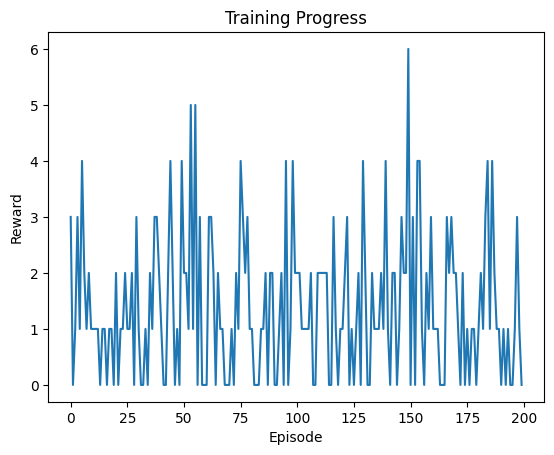

In [8]:
# Plot results
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Progress')
plt.show()